# 作业5：灰度与彩色图像的直方图均衡  

作业目的：
(1）掌握灰度直方图均衡的算法原理，并进行算法实现
(2）了解彩色图像直方图均衡的基本方法
(3）了解精确直方图匹配的算法原理


作业内容：（1）选取一张对比度不明显的彩色图像，将其转换为灰度图像。

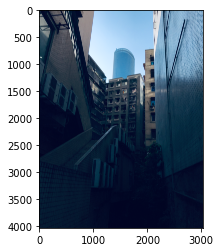

In [21]:
from skimage import *
import matplotlib.pyplot as plt

# 选择的图像
imagePath="chongqing.png"
chongqing=plt.imread(imagePath)
plt.imshow(chongqing)

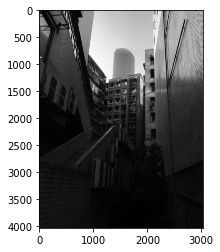

In [22]:
chongqingGray=skimage.color.rgb2gray(chongqing)
plt.imshow(chongqingGray,cmap="gray")

（2）编写PYTHON代码实现灰度图像的直方图均衡，比较均衡前后的效果

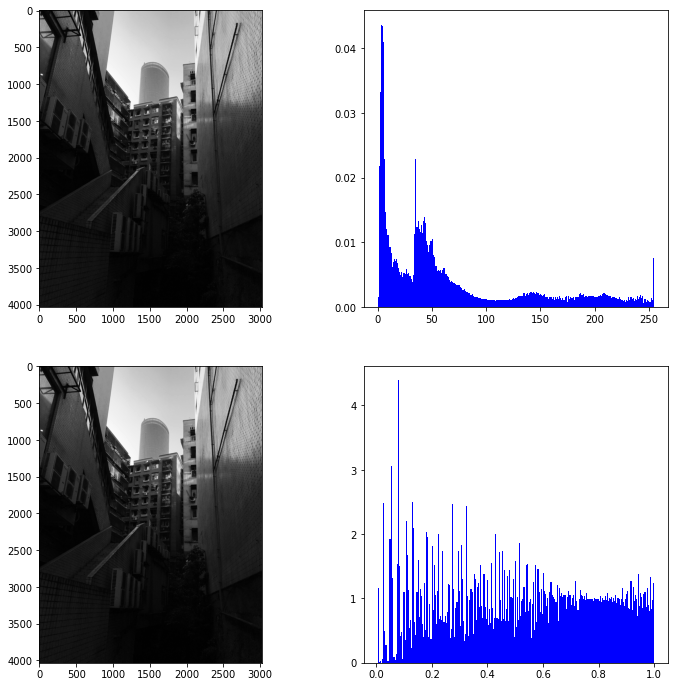

In [23]:

plt.figure("hist",figsize=(12,12))

arr=img.flatten()
plt.subplot(221)
plt.imshow(chongqingGray,cmap="gray")
plt.subplot(222)
plt.hist(arr, bins=256, density=True,edgecolor='None',facecolor='blue') #原始图像直方图

img1=exposure.equalize_hist(chongqingGray)
arr1=img1.flatten()
plt.subplot(223)
plt.imshow(chongqingGray,cmap="gray")  #均衡化图像
plt.subplot(224)
plt.hist(arr1, bins=256, density=True,edgecolor='None',facecolor='blue') #均衡化直方图

plt.show()

（3）查阅有关文档，了解彩色直方图均衡的常用方法，选取一种方法进行实现，与PHOTOSHOP的效果进行对比。

# 彩色图像的直方图均衡

## 1.按通道分别进行均衡

   对图像R,G,B三个通道分别均衡化，然后将三个通道合在一起形成均衡后的图像。
   优点是算法简单，缺点是算法可能会改变色调。

In [24]:
import numpy as np
from skimage import io,img_as_float,color

## 2.仅对亮度通道进行均衡
   为防止颜色变化，可将图像转换为HSV空间，然后仅对V通道进行均衡，最后再变换回到RGB空间

## 3.基于通道平均直方图进行均衡

统计图像R,G,B三个通道的直方图，然后对直方图进行平均，利用平均直方图构建均衡函数，最后用均衡函数对RGB三个通道进行均衡。

(4032, 3024, 3)
Elapsed time: 103.326705 seconds


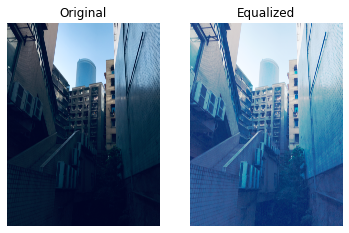

In [25]:
import numpy as np
from skimage import io,img_as_float,color
from datetime import datetime
tic = datetime.now()

img = io.imread('chongqing_8bit_no_alphaChannel.png')
plt.subplot(121)
plt.imshow(img)
plt.title("Original")
plt.axis('off')

height = img.shape[0]
width  = img.shape[1]
print(img.shape)
count_b = np.zeros(256, np.float) 
count_g = np.zeros(256, np.float)
count_r = np.zeros(256, np.float)


# 统计像素个数并计算概率
for i in range(height):
    for j in range(width):
        (b, g, r ) = img[i, j]

        index_b = int(b)
        index_g = int(g)
        index_r = int(r)

        count_b[index_b] = count_b[index_b] + 1
        count_g[index_g] = count_g[index_g] + 1
        count_r[index_r] = count_r[index_r] + 1

total = height * width 
# 计算概率
count_b =  count_b / total 
count_g =  count_g / total
count_r =  count_r / total

count_average = (count_b + count_g + count_r) / 3.0

sum_average  =  float(0)
for i in range(256):
    sum_average += count_average[i]
    count_average[i] = sum_average # 计算出累积概率

# 映射表
mapl_average = np.uint16(255 * count_average)

# 将图像进行映射
dst = np.zeros((height, width, 3), np.uint8)
for i in range(height):
    for j in range(width):
        (b, g, r) = img[i, j]
        b = mapl_average[b]
        g = mapl_average[g]
        r = mapl_average[r]

        dst[i, j] = (b, g, r)

plt.subplot(122)
plt.imshow(dst)
plt.title("Equalized")
plt.axis('off')
toc = datetime.now()
print('Elapsed time: %f seconds' % (toc-tic).total_seconds())

（4）阅读"Exact Hitogram Specification"第二部分和第三部分，写出精确直方图均衡的算法原理。如果有兴趣可以对算法进行实现，给出实现均衡效果。

根据论文的实现的算法原理，我们在直方图可以观察到（如下图所示）大概图


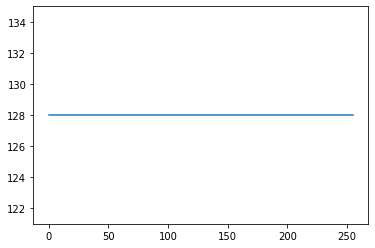

In [26]:
x=np.array([i for i in range(0,256)])
y=np.array([128 for i in range(0,256)])
plt.plot(x,y)

### 举个例子

    图像总共有25600个像素，我们给x的取值在区间[0-255]的每个灰度值都分配100个像素。
    但是并不是每个图像的直方图都如上图所示。所以我们需要精确直方图算法。
    
    灰度图像
    [[1,103,213,...,2,0],
     [1,24,218,...,3,0],
     [1,74,212,...,22,0],
     ...
     [1,163,13,...,45,0],
    ]
    其中这个例子中在[x0,y0]=[0:64]---[x1,y1]=[1:78]---[x2,y2]=[2:128]---...-[x255,y255]=[255:64]

    x0=64<100
    由于x0不够100所以要从x1中拿出100-64=36个像素点来补全x0中的像素点，让其达到100，若x1中也不足则从x2中抽取。
    
    这就出现一个问题，我们若要从x1中的像素点取出某些像素点让其灰度值变成我们要设定的灰度值，则要拿取哪些像素点？
        在这里我们要建立一个映射表，让我们找到那些x1中取出的像素点。
        这里的算法是，建立一个每个灰度值的字典，里面可以选择从上到下的相同灰度值像素点为其排序，只要保证排序序列
        没有重复，同时还记录着改像素点的位置，在我们要去补齐像素的时候，将这个像素的灰度值设定成，我们要补全像素
        的灰度值。


提交内容：
（1）PDF格式
（2）详细描述算法原理，给出实现代码和均衡前后的图像。
 (3）每位同学使用的测试图片不能相同。